## Vegetation parameter file for VIC using Oxford MAP Fractional International Geosphere-Biosphere Programme Landcover
https://code.earthengine.google.com/dataset/Oxford/MAP/IGBP_Fractional_Landcover_5km_Annual

Data availability (time)
Jan 1, 2001 - Jan 1, 2013

Resolution: 5 km

Weiss, D.J., P.M. Atkinson, S. Bhatt, B. Mappin, S.I. Hay & P.W. Gething (2014) An effective approach for gap-filling continental scale remotely sensed time-series. ISPRS Journal of Photogrammetry and Remote Sensing, 98, 106-118.

In [ ]:
%matplotlib inline
import ee
from numpy import array
import operator
import matplotlib.pyplot as plt
from folium import IFrame
import base64, folium
import datetime
import ee
import pandas as pd
import os
import numpy as np
ee.Initialize()
resolution, width, height = 75, 7, 3
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10


## LULC Classes     
1. Water
2. Evergreen_Needleleaf_Forest
3. Evergreen_Broadleaf_Forest
4. Deciduous_Needleleaf_Forest
5. Deciduous_Broadleaf_Forest
6. Mixed_Forest
7. Closed_Shrublands
8. Open_Shrublands
9. Woody_Savannas
10. Savannas
11. Grasslands
12. Permanent_Wetlands
13. Croplands
14. Urban_and_Built-up
15. Cropland_Natural_Vegetation_Mosaic
16. Snow_and_Ice
17. Barren_Or_Sparsely_Vegetated
18. Unclassified
19. No_Data 

## Get the LULC classes for years 2001-2012 

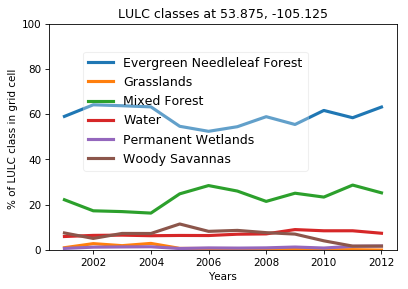

'LULC_-105.125_53.875.png'

In [586]:
#lat, lon = x, y

def make_LULC(lat, lon):
    rectangle = ee.Geometry.Rectangle([lon-0.125, lat-0.125, lon+0.125, lat+0.125]) #ll_lon, ll_lat, lon2, lat2
    lists = []
    for year in range(2001, 2013, 1):
        image = ee.Image("Oxford/MAP/IGBP_Fractional_Landcover_5km_Annual/"+str(year))#.filterDate(startTime, endTime)
        # Change the scale parameter below to see the effects
        meanDictionary = image.reduceRegion(reducer = ee.Reducer.mean(), geometry=rectangle,  scale = 300, maxPixels = 1e10)
        m = meanDictionary.getInfo()
        lists.append(m)
        sorted_m = sorted(m.items(), key=operator.itemgetter(1))
    #print(meanDictionary.getInfo())
    #print(sorted_m)
    # Plot LULC classes over time
    R = lists
    S = {k:[ R[j][k] for j in range(len(R)) ] for k in R[0].keys()}
    SigClass = {}
    for s in S:
        if sum(S[s]) > 10 and s != "Overall_Class":
            #print s
            SigClass[s.replace("_", " ")] = S[s]
    #print SigClass
    plt.figure(dpi=resolution)
    for name, values in SigClass.items():
        plt.plot(range(2001,2013), values, linewidth=3.0, label=name)
    plt.xlabel("Years")
    plt.ylabel("% of LULC class in grid cell "); plt.ylim(0,100)
    plt.title("LULC classes at {}, {}".format(lat,lon))
    leg = plt.legend(bbox_to_anchor=(0.1,0.35), fontsize=12, loc=(0,0))
    leg.get_frame().set_alpha(0.3)
    lulc_png = "LULC_{}_{}.png".format(lon,lat)
    plt.savefig(lulc_png)
    plt.show()
    plt.clf()
    return lulc_png
make_LULC(lat, lon)


## Jenny Adams Vegetation Data
http://www.hydro.washington.edu/Lettenmaier/Data/vic_global_0.5deg.html 

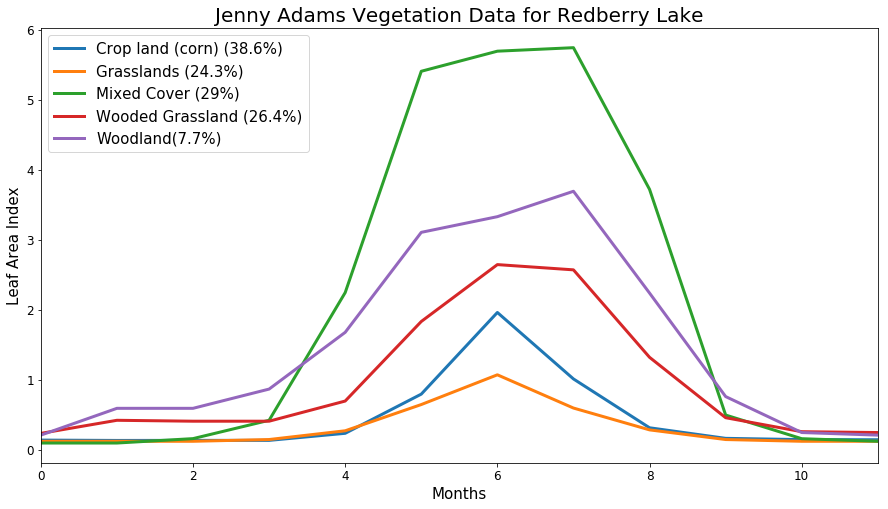

In [564]:
J = {}
J["Mixed Cover (29%)"] = [float(j) for j in "0.100 0.100 0.163 0.425 2.250 5.413 5.700 5.750 3.725 0.500 0.162 0.125".split(" ")]
J["Woodland(7.7%)"] = [float(j) for j in "0.213 0.596 0.596 0.871 1.682 3.111 3.335 3.698 2.243 0.764 0.250 0.213".split(" ")]
J["Wooded Grassland (26.4%)"] = [float(j) for j in "0.238 0.425 0.412 0.412 0.700 1.837 2.650 2.575 1.325 0.462 0.262 0.250".split(" ")]
J["Grasslands (24.3%)"] = [float(j) for j in "0.125 0.125 0.125 0.150 0.275 0.650 1.075 0.600 0.288 0.150 0.125 0.125".split(" ")]
J["Crop land (corn) (38.6%)"] = [float(j) for j in "0.142 0.137 0.138 0.138 0.239 0.799 1.966 1.016 0.318 0.167 0.149 0.147".split(" ")]

df = pd.DataFrame(J)
df = df.transpose()
"""
5 0.029 0.30 0.30 0.70 0.70
6 0.077 0.30 0.60 0.70 0.40
7 0.264 0.30 0.60 0.70 0.40
10 0.243 0.30 0.80 0.70 0.20
11 0.386 0.30 0.50 0.70 0.50
"""
df.T.plot(figsize = (15,8),linewidth = 3, fontsize=12); 
plt.ylabel("Leaf Area Index", fontsize=15); 
plt.legend(fontsize=15); plt.xlabel("Months", fontsize=15); plt.title("Jenny Adams Vegetation Data for Redberry Lake", fontsize=20)
plt.savefig("Jenny_Adams_LAI.png")

## Leaf Area Index (2003-2016)
### Leaf area index
#### Definition: one-sided green leaf area per unit ground area in broadleaf canopies; one-half the total needle surface area per unit ground area in coniferous canopies (dimensionless). Scale=0.1.

The MCD15A3H version 6 MODIS Level 4, Combined Fraction of Photosynthetically Active Radiation (FPAR), and Leaf Area Index (LAI) product is a 4-day composite data set with 500 meter pixel size.  The algorithm chooses the 'best' pixel available from all the acquisitions of both MODIS sensors located on NASA's Terra and Aqua satellites from within the 4-day period.

#### Earth Engine dataset
MCD15A3H.006 Terra+Aqua Leaf Area Index/FPAR 4-Day L4 Global 500 m


In [587]:
def make_LAI(lat, lon):
    """
    Given a point, makes a plot of LAI for 1/4th degree box around the point.
    """
    rectangle = ee.Geometry.Rectangle([lon-0.125, lat-0.125, lon+0.125, lat+0.125]) 
    lais = []
    for year in range(2003,2017):
        lai = []
        for month in range(1,13):
            startDate = str(year)+'-' + str(month)+'-01'
            if month == 2:
                endDate = str(year)+'-' + str(month)+'-28'
            else:
                endDate = str(year)+'-' + str(month)+'-30'
            imageCollection = ee.ImageCollection("MODIS/006/MCD15A3H").filterDate(startDate, endDate)
            #ee.mapclient.centerMap(-93.7848, 30.3252, 11)
            image = ee.Image(imageCollection.mean())
            data = image.reduceRegion(reducer = ee.Reducer.mean(), geometry=rectangle,  scale = 300, maxPixels = 1e10)
            lai.append(data.getInfo()["Lai"])
        lais.append(lai)
    plt.figure(dpi=resolution)
    plt.title("Leaf Area Index for {}, {}, (2003-2016)".format(lat,lon))
    for i, year in enumerate(range(2003,2017)):
        plt.scatter(np.arange(1,13,1), lais[i],label=str(year))
    
    maxValue = max([max(x) for x in lais])
    avg = [float(sum(col))/len(col) for col in zip(*lais)]
    plt.plot(np.arange(1,13,1), avg, linewidth=3.0, label="Mean")
    plt.ylabel("Leaf Area Index"); plt.ylim(0,maxValue)
    plt.xlabel("Months")
    leg = plt.legend(loc=1, fontsize=7)
    #leg = plt.legend(loc=2,fancybox=True, fontsize=14)
    leg.get_frame().set_alpha(0.3)
    png = 'LAI_{}_{}.png'.format(lon,lat)
    plt.savefig(png)
    plt.show()
    plt.clf()
    return png
#make_LAI(lat, lon)

In [594]:
path = "/home2/svimal/Github/UCLA-Hydro/ABoVE/"
os.chdir(path)
lons = [-107.375, -107.125, -107.875, -107.375, -107.125, -107.875, -105.375, -105.375,-105.125]
lats = [52.625, 52.625, 52.625, 52.875, 52.875, 52.875, 53.625, 53.875, 53.875]

m = folium.Map(location=[np.mean(lat), np.mean(lon)], zoom_start=7)

for i, lat in enumerate(lats): 
    lon = lons[i]
    
    #png = make_LAI(lat,lon)
    #lulc_png = make_LULC(lat,lon)

    png = 'LAI_{}_{}.png'.format(lon,lat)
    lulc_png = path+"LULC_{}_{}.png".format(lon,lat)
    
    encoded = base64.b64encode(open(png, 'rb').read())
    encoded2 = base64.b64encode(open(lulc_png, 'rb').read())

    html = '<img src="data:image/png;base64,{}">'.format

    iframe = IFrame(html(encoded), width=(width*resolution), height=(height*resolution)+90)
    popup = folium.Popup(iframe, max_width=2650)

    iframe2 = IFrame(html(encoded2), width=(width*resolution), height=(height*resolution)+90)
    popup2 = folium.Popup(iframe2, max_width=2650)

    icon = folium.Icon(color="green", icon="ok")
    icon2 =  folium.Icon(color="red", icon="ok")

    marker = folium.Marker(location=[lat, lon], popup=popup, icon=icon)
    marker2 = folium.Marker(location=[lat+0.025, lon], popup=popup2, icon=icon2)
 
    marker.add_to(m)
    marker2.add_to(m)
m.save('redberry2.html')
#m

In [595]:
m